# Fully connected Generative Adversarial Network
A quick implementation with a 3 000 training points dataset of sub-auroral Y2

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


We create a function to intentionally make lines to "corrupt" data for the training

The commented part allows us to make scattered lines while the uncommented one generated one single gap from `line_start` to `line_end`

In [2]:
def make_lines(array):
#     line_start=5
#     line_end=18
#     array_lines=np.copy(array)
#     for line_index in range(line_start, line_end):
#         array_lines[line_index] = np.full_like(array[line_index], np.nan)
#     return array_lines
    specificLinesIndexes = np.array([2,5,6,9,10,11,14,17,19])
    arrayLines=np.copy(array)
    for index in specificLinesIndexes:
        arrayLines[index] = np.full_like(array[index], np.nan)
    return arrayLines

Fetches all the numpy arrays in the file and store them in four datasets, train, test and train_lines, test_lines.

We instanciate matrices with train_lines_nan and test_lines_nan just for ploting confort, to have nice white lines without impacting the color scale of the plot, the version without nan replaces them with zeros to avoid the neural net from crashing.

In [3]:
numberOfFiles=0
try: 
    filesXtrain = os.listdir('../TrainingDataset/x_train/')
    numberOfFiles = len(filesXtrain)
except: print('File not found')
numberOfFiles-=11
testingSetSize = 100
mx_train_lines = np.empty((numberOfFiles-testingSetSize,24,144))
mx_train = np.empty((numberOfFiles-testingSetSize,24,144))
mx_train_lines_nan = np.empty((numberOfFiles-testingSetSize,24,144))
mx_test_lines = np.empty((testingSetSize,24,144))
mx_test_lines_nan = np.empty((testingSetSize,24,144))
mx_test = np.empty((testingSetSize,24,144))

for i in range(0,numberOfFiles-testingSetSize):
    mx_train[i] = np.load('../TrainingDataset/x_train/Y2_36_60_{}.npy'.format(i))
    mx_train_lines[i] = make_lines(mx_train[i])
    mx_train_lines_nan[i] = make_lines(mx_train[i])
for i in range(numberOfFiles-testingSetSize,numberOfFiles):
    mx_test[i-(numberOfFiles-testingSetSize)-1] = np.load('../TrainingDataset/x_train/Y2_36_60_{}.npy'.format(i))
    mx_test_lines[i-(numberOfFiles-testingSetSize)-1] = make_lines(mx_test[i-(numberOfFiles-testingSetSize)-1])
    mx_test_lines_nan[i-(numberOfFiles-testingSetSize)-1] = make_lines(mx_test[i-(numberOfFiles-testingSetSize)-1])

mx_train_lines=np.nan_to_num(mx_train_lines)
mx_train=np.nan_to_num(mx_train)
mx_test_lines=np.nan_to_num(mx_test_lines)
mx_test=np.nan_to_num(mx_test)

In [28]:
# Consistent results
np.random.seed(10)


batch_size = 50
steps_per_epoch = np.int16(numberOfFiles/batch_size)
epochs = 21

save_path = 'fcgan-images'

img_rows, img_cols, channels = 144, 24, 1

optimizer = Adam(0.0002, 0.5)

In [29]:
# Create path for saving images
if save_path is not None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [30]:
# # Load and pre-process data
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# # Normalize to between -1 and 1
# x_train = (x_train.astype(np.float32) - 127.5) / 127.5

mx_train = mx_train.reshape(-1, img_rows*img_cols*channels)
mx_train_lines = mx_train_lines.reshape(-1, img_rows*img_cols*channels)
mx_test_lines = mx_test_lines.reshape(-1, img_rows*img_cols*channels)

In [31]:
mx_train.shape

(2899, 3456)

In [8]:
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=mx_train_lines.shape[1]))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [9]:
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [32]:
discriminator = create_descriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(mx_train_lines.shape[1],))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='mse', optimizer=optimizer)

Epoch: 0 	 Discriminator Loss: 0.39278823137283325 		 Generator Loss: 0.44389405846595764
Epoch: 1 	 Discriminator Loss: 0.6961547136306763 		 Generator Loss: 0.40172871947288513


KeyboardInterrupt: 

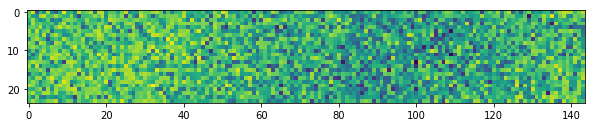

In [33]:
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(10,5)
np.random.seed(10)
for epoch in range(40):
    for batch in range(steps_per_epoch):
        fake_x = generator.predict(mx_train_lines)

        real_x = mx_train
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(x.shape[0])
        separator = np.int16(x.shape[0]/2)
        disc_y[:separator] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(real_x.shape[0])
        g_loss = gan.train_on_batch(mx_train_lines, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    
    ax1.imshow(generator.predict(mx_test_lines[10].reshape(1,-1)).reshape(24,144))
    fig.savefig("GAN_prediction_{}.png".format(epoch))
#     if epoch % 10 == 0:
#         show_images(mx_test_lines, epoch)

In [36]:
from PIL import Image, ImageDraw

frames = []
for image in range(2):
    frames.append(Image.open('GAN_prediction_{}.png'.format(image)))
frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)